In [8]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
#psi4.core.set_output_file('output.dat', False)
import time
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
from numpy.polynomial import Chebyshev
from scipy import constants
from numpy.polynomial import Polynomial

In [9]:
# z-matrix  template for H2
mol_tmpl = """
H
H 1 **R**
symmetry c1
"""

# psi4 options
options_dict = {
    "basis": "cc-pVQZ",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
    'num_roots' : 1
}
psi4.set_options(options_dict)


Going to use the results of the geometry optimization that found $r_{eq} = 0.741783$ Angstroms and
esimate the force constant using the [5-point stencil approach](https://en.wikipedia.org/wiki/Five-point_stencil):

$$ f''(r_{eq}) \approx \frac{-f(r_{eq} + 2h) + 16f(r_{eq}+h) - 30f(r_{eq}) + 16f(r_{eq}-h) - f(r_{eq}-2h)}{12 h^2} $$
where $h$ is a small displacement.  

In [10]:
# define equilibrium bondlength in Angstroms - from FCI/cc-pVQZ optimization
r_eq = 0.741783

# define displacement in Angstroms
h = 0.001

# stencil of displacements in Angstroms
r_disp = np.array([r_eq + 2*h, r_eq + h, r_eq, r_eq - h, r_eq - 2*h])

# empty array to add FCI energies to
fci_disp = []

# scan over displacements in Angstroms
for r in r_disp:
    mol_str_e = mol_tmpl.replace("**R**", str(r))
    mol_e = psi4.geometry(mol_str_e)
    scf_e, wfn = psi4.energy('SCF', return_wfn=True)
    fci_energy, wfn = psi4.energy('fci',ref_wfn=wfn, return_wfn=True)
    fci_disp.append(wfn.variable("CI ROOT 0 TOTAL ENERGY"))
    




Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYY31VALT
*** at Thu Dec  7 09:58:23 2023

   => Loading Basis Set <=

    Name: CC-PVQZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    22 file /Users/jfoley19/Code/psi4/objdir-Release/stage/share/psi4/basis/cc-pvqz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Ang

# Compute k in atomic units
Take the information in this stencil and compute $k = f''(r_{eq})$ where we want to express $r$ (and $h$) in atomic units.
The energies were computed in atomic units, but the positions and the displacement $h$ were given in Angstroms.  We must scale them appropriately so that they are in atomic units.

This force constant will be in (atomic units of force) / (atomic units of length).

1 a.u. of Force = $8.2387234983 \cdot 10^{-8}$ N

1 a.u. of length = $5.29177210903e\cdot 10^{-11}$ m

We can convert from atomic units of Force Constant to SI units of Force Constant by multiplying by $8.2387234983 \cdot 10^{-8}$ N / $5.29177210903e\cdot 10^{-11}$ m.

In [14]:
# conversion from Angstroms to a.u.
ang_to_au = 1.8897259886

# convert h from Angstroms to a.u.
h_au = h * ang_to_au

k = (-fci_disp[0] + 16 * fci_disp[1] - 30 * fci_disp[2] + 16 * fci_disp[3] - fci_disp[4]) / (12 * h ** 2)
k_au = (-fci_disp[0] + 16 * fci_disp[1] - 30 * fci_disp[2] + 16 * fci_disp[3] - fci_disp[4]) / (12 * h_au ** 2)


print(F' The K value in Hartree / Angstrom ** 2 is {k}')
print(F' The K value in Hartree / Bohr ** 2 is {k_au}')


# convert K from Hatree / Bohr / Bohr to N / m
f_au_to_SI = 8.2387234983e-8 
l_au_to_SI = 5.29177210903e-11

k_SI = k_au * f_au_to_SI / l_au_to_SI
print(F' The K value in N / m is {k_SI}')




 The K value in Hartree / Angstrom ** 2 is 1.3211541803152353
 The K value in Hartree / Bohr ** 2 is 0.3699609037785493
 The K value in N / m is 575.9895794097886


# Compute the reduced mass in atomic units
We will compute the reduced mass of the H$_2$ molecule as $\mu = \frac{m_H \cdot m_H}{m_H + m_H}$.

In [15]:
# mass of Hydrogen in atomic units
mH_amu = 1.007825032230

# conversion from amu to au of mass
amu_to_au = 1822.89

# convert H mass to atomic units
mH_au = mH_amu * amu_to_au

# compute reduced mass of H2 in atomic units
mu_au = (mH_au * mH_au) / (mH_au + mH_au)

print(F' Reduced mass in atomic units is {mu_au}')

 Reduced mass in atomic units is 918.5770865008725


# convert frequency in atomic units and the convert to wavenumbers
The Harmonic frequency in atomic units can be expressed as $\nu = \sqrt{\frac{k}{\mu}}$, 
and can be converted to wavenumbers using the conversion factor `au_to_wn = 219474.63068`

In [16]:
au_to_wn = 219474.63068

# compute Harmonic frequency of H2 in atomic units
nu_H2_au = np.sqrt(k_au / mu_au)
nu_bar_H2_wn = nu_H2_au * au_to_wn

print(F' The fundamental frequency in atomic units is {nu_H2_au}')
print(F' The fundamental frequency in cm^-1 is {nu_bar_H2_wn}')

 The fundamental frequency in atomic units is 0.020068740248772865
 The fundamental frequency in cm^-1 is 4404.579354312276


Let's identify the turning points that satisfy

$$ k (r_0 - r_{eq})^2 = \sqrt{ \frac{k}{\mu} } \rightarrow k r_0^2 -2 k r_{eq} r_0 + k r_{eq}^2 - \sqrt{ \frac{k}{\mu} }$$

Where we can solve for $r_0$ using the quadratic formula with

$a = k$

$b = -2 kr_{eq}$

$c = k r_{eq}^2 - \sqrt{ \frac{k}{\mu} }$

 Turning points are 1.1688598282281744 and 1.6346733977751728 atomic units
 Turning points are 0.6185340283614992 and 0.8650319716385007 Angstroms
 The displacement from req to get to the turning points is 0.2329067847734988 atomic units
 The displacement from req to get to the turning points is 0.12324897163850054 Angstroms


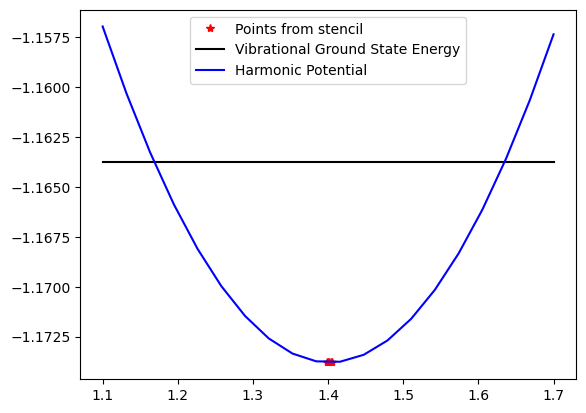

0.0028099102249978455


In [26]:
# create an array of displacements in atomic units between 1 and 1.8 atomic units
r_disp_au = np.linspace(1.1, 1.7, 20)

# equilibrium bondlength in atomic units
r_eq_au = r_disp[2] * 1.8897259886

#r_disp_au = r_disp * 1.8897259886

# turning point using quadratic formula - everything in atomic units
a = k_au
b = -2 * k_au * r_eq_au 
c = k_au * r_eq_au ** 2 - nu_H2_au

zeros_n = (-b - np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
zeros_p = (-b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)


print(F' Turning points are {zeros_n} and {zeros_p} atomic units')
print(F' Turning points are {zeros_n / 1.8897259886} and {zeros_p / 1.8897259886} Angstroms')

displacement_to_tp_au = x0_disp = ( 1 / (k_au * mu_au) ) ** (1/4)
displacement_to_tp_ang = displacement_to_tp_au / 1.8897259886

print(F' The displacement from req to get to the turning points is {displacement_to_tp_au} atomic units')
print(F' The displacement from req to get to the turning points is {displacement_to_tp_ang} Angstroms')

# evaluate the Harmonic potential on these displacements
harm_au = 1/2 * k_au * (r_disp_au - r_disp[2] * 1.8897259886) ** 2 + fci_disp[2]

# E_0 value
E_0 = np.ones_like(r_disp_au) * 0.5 * np.sqrt(k_au / mu_au) + fci_disp[2]

#plt.plot(r_disp_au, fci_disp, 'ro')
plt.plot(r_disp * 1.8897259886, fci_disp, 'r*', label="Points from stencil")
plt.plot(r_disp_au, E_0, 'black', label='Vibrational Ground State Energy')
plt.plot(r_disp_au, harm_au, 'blue', label="Harmonic Potential")
plt.legend()
plt.show()

E_ltp = 1/2 * k_au * (1.278517641363174 - r_disp[2] * 1.8897259886) ** 2
print(E_ltp)


Alternatively, find the displacements from the equilibrium that get you to the turning points:

$$  k x_0^2 = \sqrt{ \frac{k}{\mu}} \rightarrow x_0 = \left( \frac{1}{k\mu}\right)^{1/4}$$

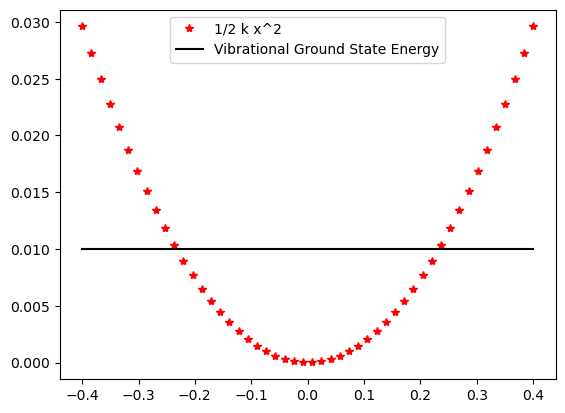

1.6346733977751726


In [23]:
# compute displacement from equilibrium to get to the turning points
x0_disp = ( 1 / (k_au * mu_au) ) ** (1/4)
x = np.linspace(-0.4, 0.4, 50)
harm_x = 1/2 * k_au * x ** 2
E_0 =  0.5 * np.sqrt(k_au / mu_au) * np.ones(50)

plt.plot(x, harm_x, 'r*', label="1/2 k x^2")
plt.plot(x, E_0, 'black', label='Vibrational Ground State Energy')
plt.legend()
plt.show()

print(x0_disp + r_eq_au)